# Applied Data Science Capstone Project 

# Table of content

* [Introduction](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Result](#Result)
* [Conclusion](#Conclusion)

# Introduction

**In February 2020 three metro stations in Warsaw are about to open.** They belong to M2 line, which has plan to fully expand in 2025 connecting western and eastern capital city outskirts. Metro in Warsaw is believed to be **the most convenient way of commuting.** It is used **thousands times** per day per every station. The main reasons behind it's popularity may be: lack of traffic, high frequency and high average speed. With **huge popularity of metro stations** comes increasing popularity in areas surrounding each station. If shops or restaurants are located in proximity of metro entrance they are exposed to flow of passengers going out or in to the metro. Similarly, flats and parkings are more expensive than they would be in no metro district of Warsaw. This phenomenom indicates that fresh new metro stations could be **a great possibility of investing.**

In this report I would like to analyze **which of new stations in Wola, Warsaw could be the best location to open a restaurant.** Results could be used to draw attention **investors interested in gastronomy.**

**To begin,** we need to import required modules:

In [1]:
!pip install folium

     |████████████████████████████████| 92kB 3.0MB/s eta 0:00:01


In [2]:
import requests
import folium
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import HeatMap

This two functions will be **useful** in the report. They add labeled points to the folium map. 

In [3]:
def add_points(lati,longi,restname,colours,map_name,op=0.7,r=15):
    for lat, lng, name, colour in zip(lati,longi,restname, colours):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.Circle(
            [lat, lng],
            radius=r,
            popup=label,
            color=colour,
            fill=True,
            fill_color=colour,
            fill_opacity=op,
            parse_html=False).add_to(map_name)

def ext_add_points(lati,longi,restname, restrating, restuser, colours,map_name,op=0.7,r=15):
    for lat, lng, name, rating, user, colour in zip(lati,longi,restname, restrating, restuser, colours):
        label = 'Name:{},\nRating:{},\nTotal ratings:{}'.format(name, rating, user)
        label = folium.Popup(label, parse_html=True)
        folium.Circle(
            [lat, lng],
            radius=r,
            popup=label,
            color=colour,
            fill=True,
            fill_color=colour,
            fill_opacity=op,
            parse_html=False).add_to(map_name)

# Data

## General insight

**First we need to prepare data of stations** we would like to analyze. Color column contain a color which dominates for a corresponding station. **Płocka is brown** due to industrial past of Wola district. **Młynów is blue** due to famous park in neighbourhood. **Księcia Janusza is green,** but no one knows why :D Our goal is to **extract** all needed informations about restaurants near metro (name, location, rating, price level, ratings number)

In [4]:
names=['Płocka', 'Młynów','Księcia Janusza']
lats=[52.233377,52.237963,52.239876]
langs=[20.966169,20.955816,20.935706]
colours=['Brown','Blue','Green']
stations = pd.DataFrame(np.array([names, lats, langs, colours]).T,columns=['Name', 'Latitude', 'Longitude','Color'])
stations

,Name,Latitude,Longitude,Color
0,Płocka,52.233377,20.966169,Brown
1,Młynów,52.237963,20.955816,Blue
2,Księcia Janusza,52.239876,20.935706,Green


Then we will **fetch data using google maps api.** We will pass each station location to gather information, like coordinates and name, about every restaurants in radius 600 meters. We would like to see it on the map, so creating folium instance is necessarily.

Define api key:

In [5]:
# The code was removed by Watson Studio for sharing.

**Gathering data:**

In [6]:
stations['Latitude']=stations['Latitude'].astype('float64')
meanlat=stations['Latitude'].mean(axis=0)
stations['Longitude']=stations['Longitude'].astype('float64')
meanlon=stations['Longitude'].mean(axis=0)

In [7]:
lati=[]
longi=[]
restname=[]
colours=[]

for x in range(3):
    url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?radius=600&location={},{}&type=restaurant&key={}'.format(stations['Latitude'][x],stations['Longitude'][x],api_key)
    result = requests.get(url).json()
    for iterator in range(len(result['results'])):
        try:
            lati.append(result['results'][iterator]['geometry']['location']['lat'])
            longi.append(result['results'][iterator]['geometry']['location']['lng'])
            restname.append(result['results'][iterator]['name'])
            colours.append(stations['Color'][x])
        except:
            pass
        
map_metro = folium.Map(tiles='cartodbpositron',location=[meanlat,meanlon], zoom_start=15)

add_points(stations['Latitude'],stations['Longitude'],stations['Name'],stations['Color'],map_metro,op=0.1,r=600)
add_points(lati,longi,restname, colours, map_metro)

Let's see **where** these restaurants are:

In [8]:
map_metro

As you can see Płocka and Młynów areas are a bit overlapping each other. That is because the distance between them is relatively small. As we see later, this fact **will not affect** our analysis.

To fully see **density of restaurants** I would propose using a **heatmap** to display restaurants locations:

In [9]:
from folium import plugins
from folium.plugins import HeatMap

map_heatmetro = folium.Map(location=[meanlat,meanlon], zoom_start=15)
folium.TileLayer('cartodbpositron').add_to(map_heatmetro)
HeatMap(zip(lati,longi),min_opacity=0.5,max_val=0.5).add_to(map_heatmetro)

add_points(stations['Latitude'], stations['Longitude'], stations['Name'], stations['Color'], map_heatmetro, op=0.1,r=600)

map_heatmetro

We can clearly see some areas where restaurant density is much higher. We can also observe at this point that **Młynów has significantly lower restaurant density** than other two stations.

Already collected data only consist of name and location. 

For further analysis we need also information about their **price level, rating and user ratings in total.** (I will later use the term rating number instead of user ratings in total)

In [10]:
lati=[]
longi=[]
restname=[]
colours=[]
ratings=[]
price=[]
user=[]
error=0
for x in range(3):
    url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?radius=600&location={},{}&type=restaurant&key={}'.format(stations['Latitude'][x],stations['Longitude'][x],api_key)
    result = requests.get(url).json()
    for iterator in range(len(result['results'])):
        try:
            price.append(result['results'][iterator]['price_level'])
            ratings.append(result['results'][iterator]['rating'])
            user.append(result['results'][iterator]['user_ratings_total'])
            lati.append(result['results'][iterator]['geometry']['location']['lat'])
            longi.append(result['results'][iterator]['geometry']['location']['lng'])
            restname.append(result['results'][iterator]['name'])
            colours.append(stations['Color'][x])
            
        except:
            error+=1
print('Number of entries which lack data: ', error)

Number of entries which lack data:  24


We will put the data in **Pandas dataframe:**

In [11]:
df = pd.DataFrame(np.array([restname,lati,longi,ratings,price,colours, user]).T, columns=['Name','Latitude','Longitude','Rating','Price Level', 'Color','Ratings Total'])

In [12]:
df['Longitude']=df['Longitude'].astype('float')
df['Latitude']=df['Latitude'].astype('float')
df['Rating']=df['Rating'].astype('float')
df['Price Level']=df['Price Level'].astype('int')
df['Ratings Total']=df['Ratings Total'].astype('int')

df.sort_values(by=['Rating'], inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df

,Name,Latitude,Longitude,Rating,Price Level,Color,Ratings Total
0,Sagarmatha Kuchnia Nepalska,52.236832,20.966512,4.7,1,Brown,467
1,Soto Sushi,52.237105,20.958994,4.4,2,Blue,134
2,Parnik Oryginalne Chińskie Pierogi 中国饺子,52.234077,20.968289,4.4,1,Brown,512
3,Masami Sushi,52.230136,20.969504,4.4,2,Brown,445
4,Makalu,52.229137,20.969076,4.4,2,Brown,352
5,Pizza Enigma,52.233175,20.967540,4.3,1,Brown,120
6,Grandfather's Pizzeria,52.234273,20.968124,4.3,1,Brown,776
7,Pizzeria Dodo,52.237408,20.965982,4.2,1,Brown,307
8,Kuchnia Orientalna,52.239714,20.935363,4.2,1,Green,91
9,Bar Mai Mai,52.237372,20.965914,4.2,1,Brown,164


Now we have dataframe consist **all restaurants in targeted areas** which have all needed informations (ratings, price level and rating number). In later stage of this report I will filter them by rating and rating number. To do so, we have to be sure that **price level does not affect rating and rating number.** Let's first compare these price levels by rating mean:

In [13]:
round(df[['Rating','Price Level']].groupby(['Price Level']).mean(),2)

,Rating
Price Level,
1,4.06
2,3.84


Although the difference in mean is **not significant,** cheaper restaurants tend to be rated **better** than more expensive ones. In this report I decided to filter restaurants by two factors: **rating and rating number.** In my opinion rating of **a good restaurant is about 3.8.** I chose minimal **rating number 150** to eliminate restaurants, which have higher rating based on only few opinions. Let's see if these assumptions are correct for this particular dataset.

First, we visualize restaurants **rating and rating number** on scatter plot. To distinct which point corresponds to which price level we will use colors:

<function matplotlib.pyplot.show(*args, **kw)>

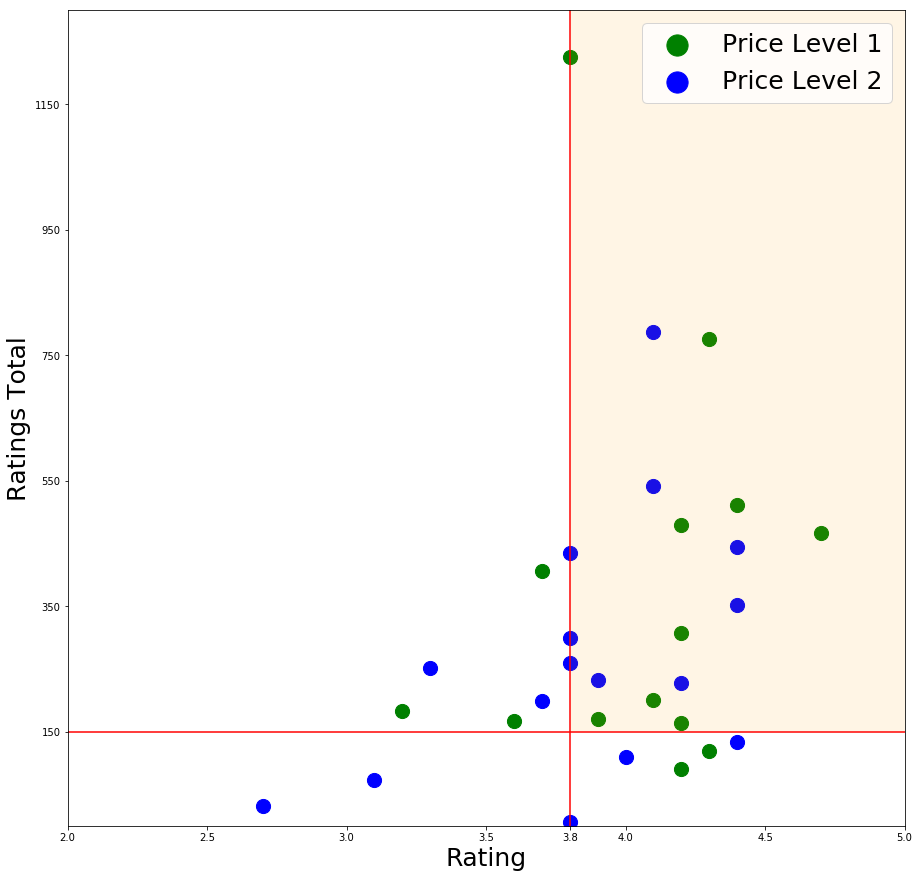

In [14]:
x=2
tick=[]
while x<=5:
    tick.append(x)
    x+=0.5
figure, axes = plt.subplots(figsize = (15,15))
df1=df[df['Price Level'] == 1]
df2=df[df['Price Level'] == 2]
scatter1 = plt.scatter(df1['Rating'], df1['Ratings Total'], c='green', s=200)
scatter2 = plt.scatter(df2['Rating'], df2['Ratings Total'], c='blue', s=200)
plt.plot([0,5],[150,150], c='red')
plt.plot([3.8,3.8],[0,1300], c='red')
plt.xticks(tick+[3.8])
plt.yticks(list(plt.yticks())[0]+[150])
plt.axis([2, 5, 0, 1300])
plt.broken_barh([(3.8, 1.2)], (150, 1300), facecolors='orange', alpha=0.1)
axes.set_xlabel('Rating', size=25)
axes.set_ylabel('Ratings Total', size=25)
plt.legend([scatter1, scatter2],['Price Level 1', 'Price Level 2'],fontsize=25, markerscale=1.5)
plt.show

Now let's create two **boxplots.** They will present **rating** and **rating number** distribution on each **price level.**

<function matplotlib.pyplot.show(*args, **kw)>

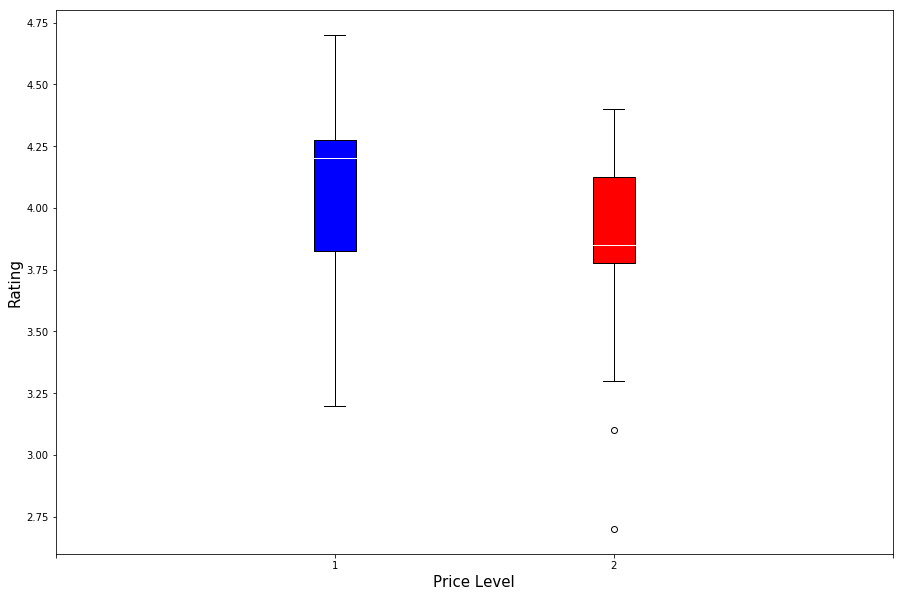

In [15]:
figure, axes = plt.subplots(figsize = (15,10))
plt.boxplot(df[df['Price Level'] == 1]['Rating'], boxprops=dict(facecolor='blue'), positions=[1],patch_artist=True,medianprops=dict(color='white'))
plt.boxplot(df[df['Price Level'] == 2]['Rating'], boxprops=dict(facecolor='red'), positions=[2],patch_artist=True,medianprops=dict(color='white'))
plt.xticks([0,1,2,3], ['',1,2])
axes.set_xlabel('Price Level', size=15)
axes.set_ylabel('Rating', size=15)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

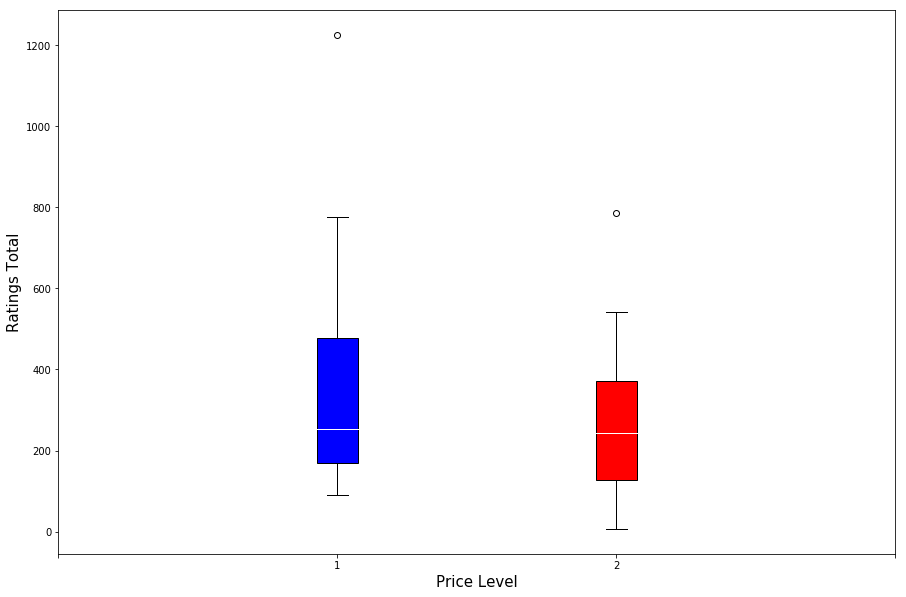

In [16]:
figure, axes = plt.subplots(figsize = (15,10))
plt.boxplot(df[df['Price Level'] == 1]['Ratings Total'], boxprops=dict(facecolor='blue'), positions=[1],patch_artist=True,medianprops=dict(color='white'))
plt.boxplot(df[df['Price Level'] == 2]['Ratings Total'], boxprops=dict(facecolor='red'), positions=[2],patch_artist=True,medianprops=dict(color='white'))
plt.xticks([0,1,2,3], ['',1,2])
axes.set_xlabel('Price Level', size=15)
axes.set_ylabel('Ratings Total', size=15)
plt.show

As we see from both boxplots, cheaper restaurants are more popular and better rated in this region. The difference itself is not significant, so I will not take this factor into account.

# Methodology

With **confident dataset** we are ready to take a closer look how restaurants are located nearby each of these stations.

To do so, we will first **filter** the restaurants and then **display** them on the map.

## Focus on particular station

Let's see how many restaurants are in each area:

In [17]:
print('Number of restaurants in each area:')
print('\tPłocka:',colours.count('Brown'))
print('\tMłynów:', colours.count('Blue'))
print('\tKsięcia Janusza:', colours.count('Green'))

Number of restaurants in each area:
	Płocka: 13
	Młynów: 4
	Księcia Janusza: 13


For each station we will do as follows:  
1. **Gather** and **filter** nearby restaurants data
1. **Create** dataframe
1. **Display** restaurants map

In each area we are looking for restaurants with **rating greater than 3.8** and **rating number over 150** (with exception of Młynów with rating number is over 100 due to only few restaurants in this area)

### a) Płocka

In [18]:
url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?radius=600&location={},{}&type=restaurant&key={}'.format(stations['Latitude'][0],stations['Longitude'][0],api_key)
result = requests.get(url).json()

In [19]:
plocka=[]
for y in range(len(result['results'])):
    try:
        if result['results'][y]['rating'] >= 3.8 and result['results'][y]['user_ratings_total'] >= 150:
            plocka.append([result['results'][y]['name'],
                           result['results'][y]['geometry']['location']['lat'],
                           result['results'][y]['geometry']['location']['lng'],
                           result['results'][y]['rating'],
                          result['results'][y]['user_ratings_total'],
                          'Brown'])
    except:
        pass
plocka = pd.DataFrame(plocka,columns=['Name','Latitude','Longitude','Rating','User total','Color'])
plocka.sort_values(by=['Rating'], inplace=True, ascending=False)
plocka.reset_index(inplace=True, drop=True)
plocka

,Name,Latitude,Longitude,Rating,User total,Color
0,Sagarmatha Kuchnia Nepalska,52.236832,20.966512,4.7,467,Brown
1,Parnik Oryginalne Chińskie Pierogi 中国饺子,52.234077,20.968289,4.4,512,Brown
2,Masami Sushi,52.230136,20.969504,4.4,445,Brown
3,Makalu,52.229137,20.969076,4.4,352,Brown
4,Grandfather's Pizzeria,52.234273,20.968124,4.3,776,Brown
5,Pizzeria Dodo,52.237408,20.965982,4.2,307,Brown
6,Bar Mai Mai,52.237372,20.965914,4.2,164,Brown
7,Kuchnia za Ścianą,52.229085,20.968672,4.2,480,Brown
8,Klubokawiarnia Pompon,52.236185,20.972048,4.1,541,Brown
9,Pizza Dominium,52.232963,20.966787,3.8,259,Brown


In [20]:
map_plocka = folium.Map(tiles='cartodbpositron',location=[stations['Latitude'][0],stations['Longitude'][0]], zoom_start=16)

add_points(plocka['Latitude'], plocka['Longitude'], plocka['Name'], plocka['Color'], map_plocka, r=10)

add_points([stations['Latitude'][0]], [stations['Longitude'][0]], [stations['Name'][0]], ['red'], map_plocka, op=1)

In [21]:
map_plocka

### b) Młynów

In [22]:
url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?radius=600&location={},{}&type=restaurant&key={}'.format(stations['Latitude'][1],stations['Longitude'][1],api_key)
result = requests.get(url).json()

In [23]:
mlynow=[]
for y in range(len(result['results'])):
    try:
        mlynow.append([result['results'][y]['name'],
                           result['results'][y]['geometry']['location']['lat'],
                           result['results'][y]['geometry']['location']['lng'],
                           result['results'][y]['rating'],
                          result['results'][y]['user_ratings_total'],
                      'Blue'])
    except:
        pass
mlynow = pd.DataFrame(mlynow,columns=['Name','Latitude','Longitude','Rating','User total','Color'])
mlynow

,Name,Latitude,Longitude,Rating,User total,Color
0,Pizza Nocą 24h Mechanizm Kręcenia,52.234961,20.959614,3.5,361,Blue
1,Cafe 66,52.240120,20.957401,4.5,28,Blue
2,Mała Italia,52.237920,20.961236,4.1,201,Blue
3,Telepizza - ul.Sokołowska 9,52.235683,20.959492,3.3,251,Blue
4,Soto Sushi,52.237105,20.958994,4.4,134,Blue
5,Grill House,52.237282,20.961781,4.2,10,Blue
6,Pizza Na Wypasie,52.234696,20.959596,3.6,167,Blue
7,zaParowani Nocą,52.234640,20.959507,3.4,12,Blue
8,Pasja Smaku,52.239037,20.964108,4.4,67,Blue


In [24]:
mlynow=[]
for y in range(len(result['results'])):
    try:
        if result['results'][y]['rating'] >= 3.8 and result['results'][y]['user_ratings_total'] >= 100:
            mlynow.append([result['results'][y]['name'],
                           result['results'][y]['geometry']['location']['lat'],
                           result['results'][y]['geometry']['location']['lng'],
                           result['results'][y]['rating'],
                          result['results'][y]['user_ratings_total'],
                          'Blue'])
        
    except:
        pass
mlynow = pd.DataFrame(mlynow,columns=['Name','Latitude','Longitude','Rating','User total','Color'])
mlynow.sort_values(by=['Rating'], inplace=True, ascending=False)
mlynow.reset_index(inplace=True, drop=True)
mlynow

,Name,Latitude,Longitude,Rating,User total,Color
0,Soto Sushi,52.237105,20.958994,4.4,134,Blue
1,Mała Italia,52.237920,20.961236,4.1,201,Blue


In [25]:
map_mlynow = folium.Map(tiles='cartodbpositron',location=[stations['Latitude'][1],stations['Longitude'][1]], zoom_start=16)

add_points(mlynow['Latitude'], mlynow['Longitude'], mlynow['Name'], mlynow['Color'], map_mlynow, r=10)

add_points([stations['Latitude'][1]], [stations['Longitude'][1]], [stations['Name'][1]], ['red'], map_mlynow, op=1)

In [26]:
map_mlynow

### c) Księcia Janusza

In [27]:
url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?radius=600&location={},{}&type=restaurant&key={}'.format(stations['Latitude'][2],stations['Longitude'][2],api_key)
result = requests.get(url).json()

In [28]:
janusz=[]
for y in range(len(result['results'])):
    try:
        janusz.append([result['results'][y]['name'],
                           result['results'][y]['geometry']['location']['lat'],
                           result['results'][y]['geometry']['location']['lng'],
                           result['results'][y]['rating'],
                          result['results'][y]['user_ratings_total'],
                      'Green'])
    except:
        pass
janusz = pd.DataFrame(janusz,columns=['Name','Latitude','Longitude','Rating','User total', 'Color'])
janusz

,Name,Latitude,Longitude,Rating,User total,Color
0,Karczma Soplicowo,52.240286,20.934455,4.1,787,Green
1,Da Grasso,52.238004,20.942017,4.2,227,Green
2,Qufel Beer Park,52.241718,20.933441,4.3,86,Green
3,Wrap&Eat Wola Park,52.241451,20.932166,2.3,22,Green
4,Burger King Wola Park,52.241994,20.932651,3.8,300,Green
5,Ichiban Sushi Wola Park,52.241744,20.932245,4.4,49,Green
6,Berlin Döner Kebap,52.241856,20.932408,3.7,199,Green
7,Restauracja Olimp,52.242028,20.932106,2.7,31,Green
8,North Fish,52.241643,20.931319,3.1,73,Green
9,Be My Juice,52.242174,20.931447,4.2,15,Green


In [29]:
janusz=[]
for y in range(len(result['results'])):
    try:
        if result['results'][y]['rating'] >= 3.8 and result['results'][y]['user_ratings_total'] >= 100:
            janusz.append([result['results'][y]['name'],
                           result['results'][y]['geometry']['location']['lat'],
                           result['results'][y]['geometry']['location']['lng'],
                           result['results'][y]['rating'],
                          result['results'][y]['user_ratings_total'],
                          'Green'])
        
    except:
        pass
janusz = pd.DataFrame(janusz,columns=['Name','Latitude','Longitude','Rating','User total', 'Color'])
janusz.sort_values(by=['Rating'], inplace=True, ascending=False)
janusz.reset_index(inplace=True, drop=True)
janusz

,Name,Latitude,Longitude,Rating,User total,Color
0,Da Grasso,52.238004,20.942017,4.2,227,Green
1,Karczma Soplicowo,52.240286,20.934455,4.1,787,Green
2,McDonald's,52.241775,20.932517,3.9,233,Green
3,Prima Pizza,52.239551,20.933913,3.9,171,Green
4,Burger King Wola Park,52.241994,20.932651,3.8,300,Green
5,KFC,52.242036,20.932421,3.8,435,Green
6,Amrit Kebab,52.238810,20.944287,3.8,1226,Green


In [30]:
map_janusz = folium.Map(tiles='cartodbpositron',location=[stations['Latitude'][2],stations['Longitude'][2]], zoom_start=16)

add_points(janusz['Latitude'], janusz['Longitude'], janusz['Name'], janusz['Color'], map_janusz, r=10)

add_points([stations['Latitude'][2]], [stations['Longitude'][2]], [stations['Name'][2]], ['red'], map_janusz, op=1)

In [31]:
map_janusz

## Combining all results

We need to combine all three dataframes from corresponding stations and visualize all restaurants on the map

In [32]:
final = pd.concat([plocka, mlynow, janusz])
final.sort_values(by=['Rating'], inplace=True, ascending=False)
final.reset_index(inplace=True, drop=True)
final

,Name,Latitude,Longitude,Rating,User total,Color
0,Sagarmatha Kuchnia Nepalska,52.236832,20.966512,4.7,467,Brown
1,Masami Sushi,52.230136,20.969504,4.4,445,Brown
2,Makalu,52.229137,20.969076,4.4,352,Brown
3,Parnik Oryginalne Chińskie Pierogi 中国饺子,52.234077,20.968289,4.4,512,Brown
4,Soto Sushi,52.237105,20.958994,4.4,134,Blue
5,Grandfather's Pizzeria,52.234273,20.968124,4.3,776,Brown
6,Pizzeria Dodo,52.237408,20.965982,4.2,307,Brown
7,Bar Mai Mai,52.237372,20.965914,4.2,164,Brown
8,Kuchnia za Ścianą,52.229085,20.968672,4.2,480,Brown
9,Da Grasso,52.238004,20.942017,4.2,227,Green


In [33]:
map_final = folium.Map(tiles='cartodbpositron',location=[stations['Latitude'][1],stations['Longitude'][1]], zoom_start=15)

add_points(stations['Latitude'],stations['Longitude'],stations['Name'],stations['Color'],map_final,op=0.1,r=600)

ext_add_points(final['Latitude'],final['Longitude'],final['Name'], final['Rating'], final['User total'], final['Color'], map_final)

In [34]:
map_final

Again **heatmap** will be more transparent

In [35]:
from folium import plugins
from folium.plugins import HeatMap

map_heatfinal = folium.Map(location=[stations['Latitude'][1],stations['Longitude'][1]], zoom_start=15)
folium.TileLayer('cartodbpositron').add_to(map_heatfinal)
HeatMap(zip(final['Latitude'],final['Longitude']),min_opacity=0.5,max_val=0.5).add_to(map_heatfinal)

add_points(stations['Latitude'], stations['Longitude'], stations['Name'], stations['Color'], map_heatfinal, op=0.1,r=600)

map_heatfinal

Restaurants seem to be *aggregated* in some areas. To separate them I will use **kmeans** algorithm.  

In [36]:
from sklearn.cluster import KMeans

number_of_clusters = 5

kmeans = KMeans(n_clusters=number_of_clusters).fit(final[['Latitude','Longitude']])

loc=[]
for cc in kmeans.cluster_centers_:
    loc.append([cc[0],cc[1]])

map_cluster = folium.Map(location=[stations['Latitude'][1],stations['Longitude'][1]], zoom_start=15, max_zoom=15)
folium.TileLayer('cartodbpositron').add_to(map_cluster)

for coordinates in loc:
    folium.Circle([coordinates[0], coordinates[1]], radius=250,color='white' ,fill_color='purple', fill=True, fill_opacity=0.3).add_to(map_cluster) 
for coordinates in loc:
    folium.Circle([coordinates[0], coordinates[1]], radius=20,color='orange', fill=True, fill_opacity=1).add_to(map_cluster) 

add_points(stations['Latitude'], stations['Longitude'], stations['Name'], stations['Color'], map_cluster, op=0.1,r=600)

ext_add_points(final['Latitude'],final['Longitude'],final['Name'], final['Rating'], final['User total'], final['Color'], map_cluster)

map_cluster

# Result & Discussion

Final cluster map clearly depicts differences between each metro station neighbourhood.

**Płocka (brown color)** has some free space although it already consists two clusters with relatively **high restaurant density.** But both clusters are in some distance from the station so if Investor has an opportunity to rent a place just near the entrance, it may be profitable but risky.    

**Księcia Janusza (green color)** is **a difficult location** due to Wola Park, a shopping centre near the station. Wola Park attracts many citizens, but comes with **bigger competition.** Most of the restaurants in this area are famous brands like KFC or McDonald. The opportunity here is to seek for location near Górczewska, which is the main street. Probably **a vegan restaurant** serving healthy meals could fill the gap left by junky fast-foods.  

**Młynów (blue color) seems to be the best choice.** **Low restaurant density** with **famous park** nearby may bring **many** customers. This area also includes suburban railway station, Moczydło (an aquapark during summer, an icerink during winter) and Moczydło park. **Only two restaurants should be taken into account** when choosing a type of future restaurant. One of them serves italian cuisine while other serves sushi. Investor may be interested in chinese **takeaways or kebab.**

# Conclusion

Final cluster map clearly depicts which area is open for new possibilities. While **Młynów** has only one cluster consisting just two restaurants, it has also popular park nearby. In addition, recently built suburban railway station may even increase number of potencial customers. Future investor may be sure that there are not many competitors in this area. 